## Comparación entre ambos modelos

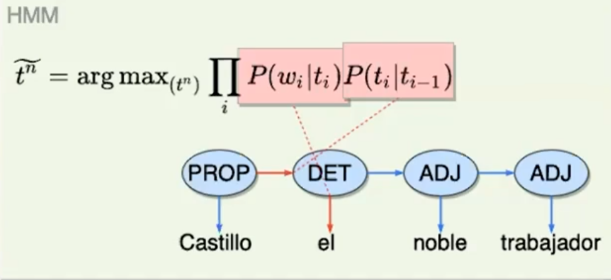
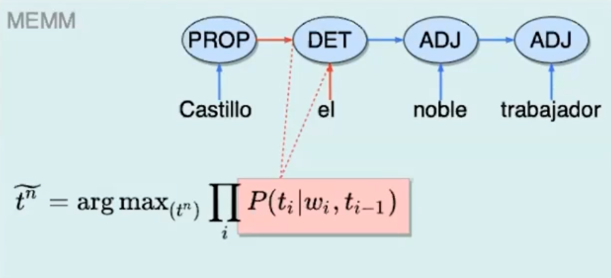

In [1]:
import pandas as pd
import numpy as np

from conllu import parse_incr

In [2]:
from pathlib import Path
url = 'https://github.com/UniversalDependencies/UD_Spanish-AnCora.git'
path = Path('/tmp/spanish-corpus/')

In [3]:
!git clone $url $path && echo 'Done.'

fatal: destination path '/tmp/spanish-corpus' already exists and is not an empty directory.


In [4]:
word_list = []
first_word_list = []
counter = 0
conllu_file = 'es_ancora-ud-dev.conllu'
with open(path / conllu_file, 'r', encoding='utf-8') as f:
    for tokenlist in parse_incr(f):
        for token in tokenlist:
            word_list.append(token)
        first_word_list.append(tokenlist[0])

In [5]:
tag_name = "upos"
word_name = "form"
tag_prev_name = f"{tag_name}_prev"

In [6]:
df = pd.DataFrame(word_list)[[word_name, tag_name]]
df[tag_prev_name] = df[tag_name].shift()
df[word_name] = df[word_name].str.lower()
df.head()

,form,upos,upos_prev
0,el,DET,None
1,gobernante,NOUN,DET
2,",",PUNCT,NOUN
3,con,ADP,PUNCT
4,ganada,ADJ,ADP


Necesitaremos las siguientes probabilidades:
$$
\begin{align*}
    P(\text{tag} | \text{word} , \text{prevtag}) = \
        P((tag | word)|prevtag) P(prevtag)
\end{align*}
$$

In [105]:
count_word_tag_tag_prev = df[[word_name, tag_name, tag_prev_name]].drop(index=0).value_counts()
count_word_tag_prev = df[[word_name, tag_prev_name]].drop(index=0).value_counts()

prob_first_tag = pd.DataFrame(first_word_list)["upos"].value_counts(normalize=True)

In [12]:
query = count_word_tag_tag_prev.droplevel(level=tag_name).index
prob = count_word_tag_tag_prev / count_word_tag_prev.loc[query].values
prob = prob.reorder_levels([word_name, tag_name, tag_prev_name])
prob = prob.sort_index(level=[tag_name, tag_prev_name, word_name])

In [285]:
first_df = pd.DataFrame(first_word_list)[["upos"]]
rho = first_df.value_counts(normalize=True)
rho["SYM"] = 0
rho = rho.sort_index()
rho

upos 
ADJ      0.010883
ADP      0.155381
ADV      0.056832
AUX      0.016324
CCONJ    0.032648
DET      0.362757
INTJ     0.000605
NOUN     0.027207
NUM      0.019952
PART     0.001814
PRON     0.063482
PROPN    0.112455
PUNCT    0.082225
SCONJ    0.024184
SYM      0.000000
VERB     0.024184
_        0.009069
dtype: float64

In [19]:
from nltk import word_tokenize

In [20]:
from typing import Iterable, Union
text_type = Union[str, Iterable[str]]
df_type = Union[pd.DataFrame, pd.Series]

In [330]:
def viterbi_memm(
        text: text_type,
        corpus: df_type = df,
        rho: df_type = rho,
):
        df = corpus
        tag_enum = np.unique(df[tag_name])
        count_word_tag_tag_prev = df[[word_name, tag_name, tag_prev_name]].drop(index=0).value_counts()
        count_word_tag_prev = df[[word_name, tag_prev_name]].drop(index=0).value_counts()
        query = count_word_tag_tag_prev.droplevel(level=tag_name).index
        prob = count_word_tag_tag_prev / count_word_tag_prev.loc[query].values 
        prob = prob.reorder_levels([word_name, tag_name, tag_prev_name])
        prob = prob.sort_index(level=[tag_name, tag_prev_name, word_name])

        if isinstance(text, str):
                text = word_tokenize(text)

        tt = df[[word_name,tag_name]].value_counts(normalize=True).to_xarray().fillna(0).sel(**{word_name: text})
        prob = prob.to_xarray().fillna(0)
        prob = prob.sel(**{word_name: text})

        if not np.any(prob):
                raise NotImplemented()

        res = []
        res_0 = tt.sel(**{word_name: text[0]}) * rho.values
        res.append(res_0)
        for i, word in enumerate(text[1:]):
                prev_row = res[-1]
                # print(prev_row)
                res.append(
                        np.einsum('j,kj->k',prev_row, prob.sel(**{word_name: word}))
                )

        return [tag_enum[int(x.argmax())] for x in res]

In [333]:
viterbi_memm('el mundo es pequeño.')

['DET', 'NOUN', 'AUX', 'ADJ', 'ADJ']